In [1]:
import os
import sys
import tqdm
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from numpy.random import seed
from skopt import BayesSearchCV
from sklearn.base import BaseEstimator
from sklearn.metrics import mean_squared_error

sys.path.append('.')
sys.path.append('../../')
sys.path.append('../network_model/')
sys.path.append('../validation/')

notebook_path = os.getcwd()
project_path = os.path.abspath(os.path.join(notebook_path, '..'))
sys.path.append(project_path)

from network_model.network_classes import Network
from networks_container import NetworksContainer
from estimator import Estimator

In [2]:
cherrypicked_seed = 42

seed(cherrypicked_seed)
random.seed(cherrypicked_seed)

In [3]:
epochs = 1000

In [4]:
n_nodes = 2000
n_nodes

2000

In [5]:
n_bots = round((2 / 100) * n_nodes)
n_bots

40

In [6]:
n_fact_checkers = round((2 / 100) * n_nodes)
n_fact_checkers

40

In [7]:
n_influencers = 20

In [8]:
n_commons = n_nodes - n_bots - n_fact_checkers - n_influencers
n_commons

1900

In [9]:
n_initial_infected_nodes = round((5 / 100) * n_nodes) - n_bots
n_initial_infected_nodes

60

In [10]:
parameters_df = pd.read_csv("../validation/parameters/parameters_optimization_palin_hours_homophily_0.50.csv")

In [11]:
parameters_df = parameters_df.sort_values(by='rmse')
parameters_df

,alpha,beta,homophily,prob_infection,prob_vaccination,prob_cure,prob_influencer,prob_echo,rmse
16,0.50,0.33,0.5,0.360038,0.056790,0.216255,0.098907,0.617839,1.405257
17,0.50,0.50,0.5,0.454669,0.098769,0.211907,0.101289,0.250256,2.821633
15,0.50,0.25,0.5,0.308446,0.007363,0.157705,0.510944,0.549876,2.909999
19,0.75,0.25,0.5,0.448473,0.139018,0.030732,0.006663,0.825364,3.469475
9,0.25,0.75,0.5,0.471125,0.095869,0.172569,0.407868,0.015595,3.713381
12,0.33,0.33,0.5,0.317698,0.007074,0.214766,0.499534,0.120162,9.119578
13,0.33,0.50,0.5,0.439607,0.077711,0.071581,0.018257,0.299499,11.036833
8,0.25,0.50,0.5,0.481207,0.075433,0.153820,0.221028,0.824805,11.741975
6,0.25,0.25,0.5,0.418224,0.000221,0.119561,0.112658,0.001969,15.698193
4,0.00,0.75,0.5,0.437207,0.035077,0.234331,0.816667,0.986421,16.186571


In [12]:
alpha = parameters_df['alpha'].iloc[0]
beta = parameters_df['beta'].iloc[0]
homophily = parameters_df['homophily'].iloc[0]
prob_infection = parameters_df['prob_infection'].iloc[0]
prob_vaccination = parameters_df['prob_vaccination'].iloc[0]
prob_cure = parameters_df['prob_cure'].iloc[0]
prob_influencer = parameters_df['prob_influencer'].iloc[0]
prob_echo = parameters_df['prob_echo'].iloc[0]

In [13]:
prob_complaint = 0.00 

In [14]:
container = NetworksContainer(n_networks=30, n_nodes=n_nodes, 
                              alpha=alpha, beta=beta, 
                              delta_in=1, delta_out=1, 
                              homophily=homophily, n_commons=n_commons, 
                              n_influencers=n_influencers, n_bots=n_bots, 
                              n_fact_checkers=n_fact_checkers,
                              prob_complaint=prob_complaint, 
                              prob_infection=prob_infection, 
                              prob_vaccination=prob_vaccination,
                              prob_cure=prob_cure, 
                              prob_influencer=prob_influencer, 
                              exp_decay=True, user_block=False, 
                              prob_echo=prob_echo, epochs=epochs)
container.create_network_list(n_initial_infected_nodes=n_initial_infected_nodes)

In [15]:
total_y_pred_list = []

for i in range(container.n_networks):   
    y_pred_list = []
    container.network_list[i].reset_network()
    for j in range(container.epochs):
        container.network_list[i].update_nodes()
    y_pred_list = container.network_list[i].perc_infected
    total_y_pred_list.append(y_pred_list)

In [16]:
total_y_pred_list_influencer_vacc = []

for i in range(container.n_networks):   
    y_pred_list = []
    container.network_list[i].reset_network()
    container.set_influencers_to_vaccinated()
    for j in range(container.epochs):
        container.network_list[i].update_nodes()
    y_pred_list = container.network_list[i].perc_infected
    total_y_pred_list_influencer_vacc.append(y_pred_list)

In [17]:
avg_y_pred_list = [sum(column) / len(column) for column in zip(*total_y_pred_list)]
avg_y_pred_list_influencer_vacc = [sum(column) / len(column) for column in zip(*total_y_pred_list_influencer_vacc)]

In [18]:
std_y_pred_list = [np.std(column) for column in zip(*total_y_pred_list)]
std_y_pred_list_influencer_vacc = [np.std(column) for column in zip(*total_y_pred_list_influencer_vacc)]

In [19]:
std_low_y_pred_list = []
std_high_y_pred_list = []

for i in range(len(avg_y_pred_list)):
    std_low_y_pred_list.append(avg_y_pred_list[i] - std_y_pred_list[i])
    std_high_y_pred_list.append(avg_y_pred_list[i] + std_y_pred_list[i])

In [20]:
std_low_y_pred_list_influencer_vacc = []
std_high_y_pred_list_influencer_vacc = []

for i in range(len(avg_y_pred_list_influencer_vacc)):
    std_low_y_pred_list_influencer_vacc.append(avg_y_pred_list_influencer_vacc[i] - std_y_pred_list_influencer_vacc[i])
    std_high_y_pred_list_influencer_vacc.append(avg_y_pred_list_influencer_vacc[i] + std_y_pred_list_influencer_vacc[i])

In [21]:
x = []
for i in range(epochs + 1):
    x.append(i)

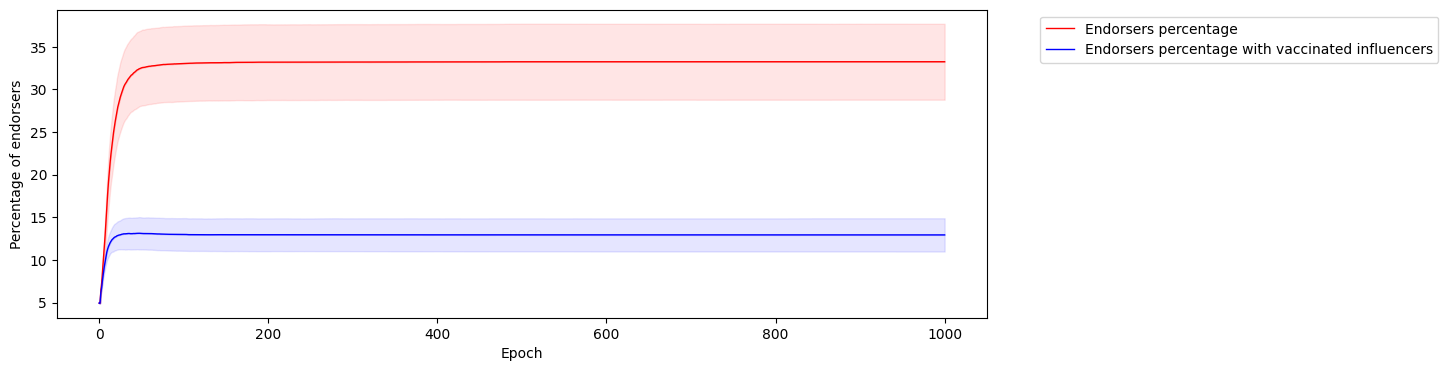

In [22]:
fig, axs = plt.subplots(1, 1, figsize=(12, 4))
axs.plot(avg_y_pred_list, c='r', label='Endorsers percentage', linewidth=1.0)
axs.fill_between(x, avg_y_pred_list, std_low_y_pred_list, color='r', alpha=.1)
axs.fill_between(x, avg_y_pred_list, std_high_y_pred_list, color='r', alpha=.1)
plt.plot(avg_y_pred_list_influencer_vacc, c='b', label='Endorsers percentage with vaccinated influencers', linewidth=1.0)
axs.fill_between(x, avg_y_pred_list_influencer_vacc, std_low_y_pred_list_influencer_vacc, color='b', alpha=.1)
axs.fill_between(x, avg_y_pred_list_influencer_vacc, std_high_y_pred_list_influencer_vacc, color='b', alpha=.1)
legend = plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xlabel("Epoch")
plt.ylabel("Percentage of endorsers")
plt.show()

In [23]:
df_total_y_pred = pd.DataFrame(total_y_pred_list).T
df_total_y_pred.to_csv("simulation_influencer_obama_endorsers_percentages.csv", index=False, header=False)

In [24]:
df_total_y_pred = pd.DataFrame(total_y_pred_list_influencer_vacc).T
df_total_y_pred.to_csv("simulation_influencer_vaccinated_obama_endorsers_percentages.csv", index=False, header=False)

In [25]:
df_statistics = pd.DataFrame(avg_y_pred_list).T
df_statistics.loc[1] = std_y_pred_list
df_statistics.loc[2] = std_high_y_pred_list
df_statistics.loc[3] = std_low_y_pred_list
df_statistics.loc[4] = avg_y_pred_list_influencer_vacc
df_statistics.loc[5] = std_y_pred_list_influencer_vacc
df_statistics.loc[6] = std_high_y_pred_list_influencer_vacc
df_statistics.loc[7] = std_low_y_pred_list_influencer_vacc
df_statistics.to_csv("simulation_influencer_obama_statistics.csv", index=False, header=False)